In [11]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.auto import tqdm
import os
from nltk.translate.bleu_score import sentence_bleu
import nltk
from sacremoses import MosesTokenizer, MosesDetokenizer
from collections import defaultdict
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import gc
from collections import Counter

# Download required NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

C:\Users\urjap\anaconda3\envs\env\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\Users\urjap\anaconda3\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\urjap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\urjap\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
# Cell 2: Define the SanskritEnglishDataset class
class SanskritEnglishDataset(Dataset):
    def __init__(self, data, sanskrit_vocab, english_vocab, max_length=64):
        self.data = data
        self.sanskrit_vocab = sanskrit_vocab
        self.english_vocab = english_vocab
        self.max_length = max_length
        self.sanskrit_tokenizer = MosesTokenizer(lang='sa')
        self.english_tokenizer = MosesTokenizer(lang='en')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sanskrit = item['content']
        english = item['explanation']

        sanskrit_tokens = self.sanskrit_tokenizer.tokenize(sanskrit)
        english_tokens = self.english_tokenizer.tokenize(english)

        sanskrit_indices = [self.sanskrit_vocab.get(token, self.sanskrit_vocab['<UNK>']) for token in sanskrit_tokens]
        english_indices = [self.english_vocab.get(token, self.english_vocab['<UNK>']) for token in english_tokens]

        sanskrit_indices = self._pad_sequence(sanskrit_indices)
        english_indices = self._pad_sequence(english_indices)

        return {
            'sanskrit': torch.tensor(sanskrit_indices),
            'english': torch.tensor(english_indices)
        }

    def _pad_sequence(self, sequence):
        if len(sequence) > self.max_length:
            return sequence[:self.max_length]
        return sequence + [0] * (self.max_length - len(sequence))

In [13]:
# Cell 3: Define the SanskritSMT class
class SanskritSMT:
    def __init__(self):
        self.translation_table = defaultdict(lambda: defaultdict(int))
        self.sanskrit_tokenizer = MosesTokenizer(lang='sa')
        self.english_tokenizer = MosesTokenizer(lang='en')
        self.english_detokenizer = MosesDetokenizer(lang='en')
        self.word_alignments = defaultdict(list)

    def train(self, train_data):
        print("Training SMT model...")
        for index, row in tqdm(train_data.iterrows(), total=len(train_data)):
            sanskrit = row['content']
            english = row['explanation']

            sanskrit_tokens = self.sanskrit_tokenizer.tokenize(sanskrit)
            english_tokens = self.english_tokenizer.tokenize(english)

            for i, s_token in enumerate(sanskrit_tokens):
                for j, e_token in enumerate(english_tokens):
                    self.translation_table[s_token][e_token] += 1
                    self.word_alignments[s_token].append((i, j))

    def translate(self, sanskrit_text):
        sanskrit_tokens = self.sanskrit_tokenizer.tokenize(sanskrit_text)
        translated_tokens = []

        for s_token in sanskrit_tokens:
            if s_token in self.translation_table:
                translations = self.translation_table[s_token]
                if translations:
                    best_translation = max(translations.items(), key=lambda x: x[1])[0]
                    translated_tokens.append(best_translation)
                else:
                    translated_tokens.append(s_token)
            else:
                translated_tokens.append(s_token)

        return self.english_detokenizer.detokenize(translated_tokens)

In [14]:
# Cell 4: Define the evaluate_translation function
def evaluate_translation(reference, hypothesis):
    """Calculate BLEU score and other metrics"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens)

    overlap = len(set(reference_tokens) & set(hypothesis_tokens))
    total = len(set(reference_tokens) | set(hypothesis_tokens))
    overlap_score = overlap / total if total > 0 else 0

    return {
        'bleu': bleu_score,
        'word_overlap': overlap_score
    }

In [15]:
# Cell 5: Load Data and Build Vocabulary
df = pd.read_csv("sundarakanda.csv")

print("Building vocabularies...")
sanskrit_tokenizer = MosesTokenizer(lang='sa')
english_tokenizer = MosesTokenizer(lang='en')

sanskrit_counter = Counter()
english_counter = Counter()

for index, row in tqdm(df.iterrows(), total=len(df)):
    sanskrit_tokens = sanskrit_tokenizer.tokenize(row['content'])
    english_tokens = english_tokenizer.tokenize(row['explanation'])
    sanskrit_counter.update(sanskrit_tokens)
    english_counter.update(english_tokens)

sanskrit_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}
english_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}

for token, _ in sanskrit_counter.most_common(10000):
    sanskrit_vocab[token] = len(sanskrit_vocab)

for token, _ in english_counter.most_common(10000):
    english_vocab[token] = len(english_vocab)

print("Vocabulary building complete.")

Building vocabularies...


100%|████████████████████████████████████████████████████████████████████████████| 2535/2535 [00:02<00:00, 1083.53it/s]

Vocabulary building complete.


In [17]:
# Cell 6: Train SMT Model and Example Translation
smt_model = SanskritSMT()
print("\nTraining SMT model...")
smt_model.train(df)
print("SMT training complete.")



Training SMT model...
Training SMT model...


100%|█████████████████████████████████████████████████████████████████████████████| 2535/2535 [00:04<00:00, 619.82it/s]

SMT training complete.


In [21]:
# Cell 4: Define the evaluate_translation function
def evaluate_translation(reference, hypothesis):
    """Calculate BLEU score and other metrics"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    # BLEU score with smoothing
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)

    overlap = len(set(reference_tokens) & set(hypothesis_tokens))
    total = len(set(reference_tokens) | set(hypothesis_tokens))
    overlap_score = overlap / total if total > 0 else 0

    return {
        'bleu': bleu_score,
        'word_overlap': overlap_score
    }

Evaluating SMT model...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [00:07<00:00, 71.45it/s]


Average BLEU score: 0.0126
Average Word Overlap score: 0.1061


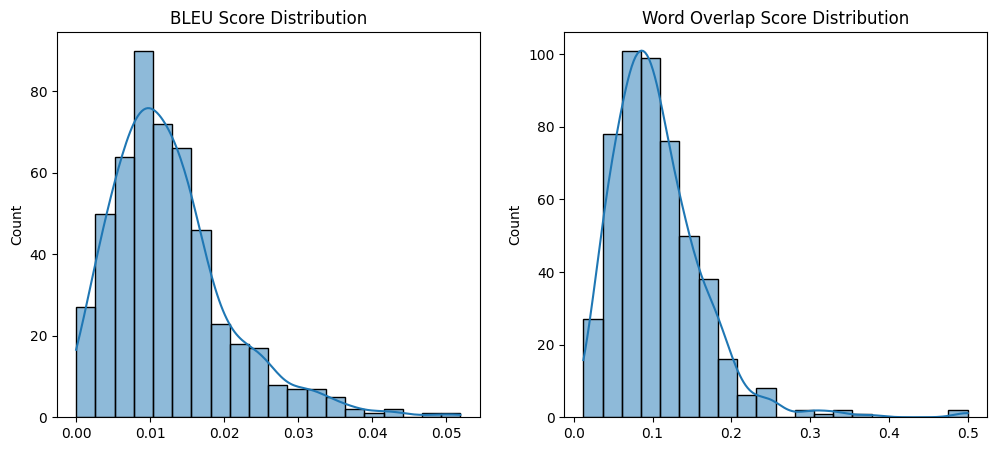

In [36]:
# Cell 7: Evaluation Code

# Assuming you have a test dataset (e.g., split from your original DataFrame)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Initialize evaluation metrics
bleu_scores_smt = []
overlap_scores_smt = []

print("Evaluating SMT model...")
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    reference = str(row['explanation'])  # Ensure reference is a string
    hypothesis = smt_model.translate(row['content'])

    evaluation_results = evaluate_translation(reference, hypothesis)
    bleu_scores_smt.append(evaluation_results['bleu'])
    overlap_scores_smt.append(evaluation_results['word_overlap'])

# Calculate average scores
average_bleu_smt = np.mean(bleu_scores_smt)
average_overlap_smt = np.mean(overlap_scores_smt)

print(f"Average BLEU score: {average_bleu_smt:.4f}")
print(f"Average Word Overlap score: {average_overlap_smt:.4f}")

# Optional: Visualize the distribution of scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(bleu_scores_smt, bins=20, kde=True)
plt.title("BLEU Score Distribution")

plt.subplot(1, 2, 2)
sns.histplot(overlap_scores_smt, bins=20, kde=True)
plt.title("Word Overlap Score Distribution")

plt.show()

In [23]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
from sacremoses import MosesTokenizer, MosesDetokenizer
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [24]:
# Cell 2: Define SanskritEnglishDataset class
class SanskritEnglishDataset(Dataset):
    def __init__(self, data, sanskrit_vocab, english_vocab, max_length=64):
        self.data = data
        self.sanskrit_vocab = sanskrit_vocab
        self.english_vocab = english_vocab
        self.max_length = max_length
        self.sanskrit_tokenizer = MosesTokenizer(lang='sa')
        self.english_tokenizer = MosesTokenizer(lang='en')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sanskrit = item['content']
        english = item['explanation']

        sanskrit_tokens = self.sanskrit_tokenizer.tokenize(sanskrit)
        english_tokens = self.english_tokenizer.tokenize(english)

        sanskrit_indices = [self.sanskrit_vocab.get(token, self.sanskrit_vocab['<UNK>']) for token in sanskrit_tokens]
        english_indices = [self.english_vocab.get(token, self.english_vocab['<UNK>']) for token in english_tokens]

        sanskrit_indices = sanskrit_indices[:self.max_length] + [0] * (self.max_length - len(sanskrit_indices))
        english_indices = [self.english_vocab['<START>']] + english_indices + [self.english_vocab['<END>']]
        english_indices = english_indices[:self.max_length] + [0] * (self.max_length - len(english_indices))

        return {
            'sanskrit': torch.tensor(sanskrit_indices),
            'english': torch.tensor(english_indices),
            'english_input': torch.tensor(english_indices[:-1]),
            'english_output': torch.tensor(english_indices[1:])
        }

In [25]:
# Cell 3: Define SanskritNMT class
class SanskritNMT(nn.Module):
    def __init__(self, sanskrit_vocab_size, english_vocab_size, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.sanskrit_embedding = nn.Embedding(sanskrit_vocab_size, embedding_dim)
        self.english_embedding = nn.Embedding(english_vocab_size, embedding_dim)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim * 2, num_layers=2, batch_first=True)

        self.output_layer = nn.Linear(hidden_dim * 2, english_vocab_size)

        self.to(self.device)

    def forward(self, sanskrit, english_input):
        sanskrit_embedded = self.sanskrit_embedding(sanskrit)
        english_embedded = self.english_embedding(english_input)

        encoder_outputs, (hidden, cell) = self.encoder(sanskrit_embedded)

        hidden = hidden.view(2, 2, -1, hidden.size(2))
        hidden = hidden.permute(1, 0, 2, 3).contiguous().view(2, -1, hidden.size(3) * 2)
        cell = cell.view(2, 2, -1, cell.size(2))
        cell = cell.permute(1, 0, 2, 3).contiguous().view(2, -1, cell.size(3) * 2)

        decoder_outputs, _ = self.decoder(english_embedded, (hidden, cell))

        output = self.output_layer(decoder_outputs)

        return output

    def translate(self, sanskrit_text, sanskrit_vocab, english_vocab, max_length=64):
        self.eval()
        sanskrit_tokenizer = MosesTokenizer(lang='sa')
        english_detokenizer = MosesDetokenizer(lang='en')

        sanskrit_tokens = sanskrit_tokenizer.tokenize(sanskrit_text)
        sanskrit_indices = [sanskrit_vocab.get(token, sanskrit_vocab['<UNK>']) for token in sanskrit_tokens]

        sanskrit_indices = sanskrit_indices[:max_length] + [0] * (max_length - len(sanskrit_indices))

        sanskrit_tensor = torch.tensor([sanskrit_indices]).to(self.device)

        with torch.no_grad():
            sanskrit_embedded = self.sanskrit_embedding(sanskrit_tensor)

            encoder_outputs, (hidden, cell) = self.encoder(sanskrit_embedded)

            hidden = hidden.view(2, 2, -1, hidden.size(2))
            hidden = hidden.permute(1, 0, 2, 3).contiguous().view(2, -1, hidden.size(3) * 2)
            cell = cell.view(2, 2, -1, cell.size(2))
            cell = cell.permute(1, 0, 2, 3).contiguous().view(2, -1, cell.size(3) * 2)

            decoder_input = torch.tensor([[english_vocab['<START>']]]).to(self.device)
            translated_indices = []

            for _ in range(max_length):
                decoder_embedded = self.english_embedding(decoder_input)
                decoder_outputs, (hidden, cell) = self.decoder(decoder_embedded, (hidden, cell))
                output = self.output_layer(decoder_outputs[:, -1])

                next_token = output.argmax(dim=1)
                translated_indices.append(next_token.item())

                if next_token.item() == english_vocab['<END>']:
                    break

                decoder_input = next_token.unsqueeze(0)

        translated_tokens = []
        for idx in translated_indices:
            if idx in english_vocab.values():
                token = list(english_vocab.keys())[list(english_vocab.values()).index(idx)]
                if token not in ['<START>', '<END>', '<PAD>', '<UNK>']:
                    translated_tokens.append(token)

        return english_detokenizer.detokenize(translated_tokens)

In [27]:
# Cell 5: Training NMT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split

gc.collect()
torch.cuda.empty_cache()

nmt_model = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
train_loader = DataLoader(nmt_dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(nmt_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 5

print("\nTraining NMT model...")
for epoch in range(num_epochs):
    nmt_model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model.device)
        english_input = batch['english_input'].to(nmt_model.device)
        english_output = batch['english_output'].to(nmt_model.device)
        output = nmt_model(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
print("NMT training complete.")


Training NMT model...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [08:16<00:00,  1.95s/it]


Epoch 1/5, Average Loss: 6.0146


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [08:08<00:00,  1.92s/it]


Epoch 2/5, Average Loss: 5.1124


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [08:10<00:00,  1.93s/it]


Epoch 3/5, Average Loss: 4.5620


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [08:11<00:00,  1.93s/it]


Epoch 4/5, Average Loss: 4.0263


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [08:10<00:00,  1.93s/it]

Epoch 5/5, Average Loss: 3.4062
NMT training complete.


Evaluating NMT model...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [06:01<00:00,  1.40it/s]


Average BLEU score: 0.0213
Average Word Overlap score: 0.1238


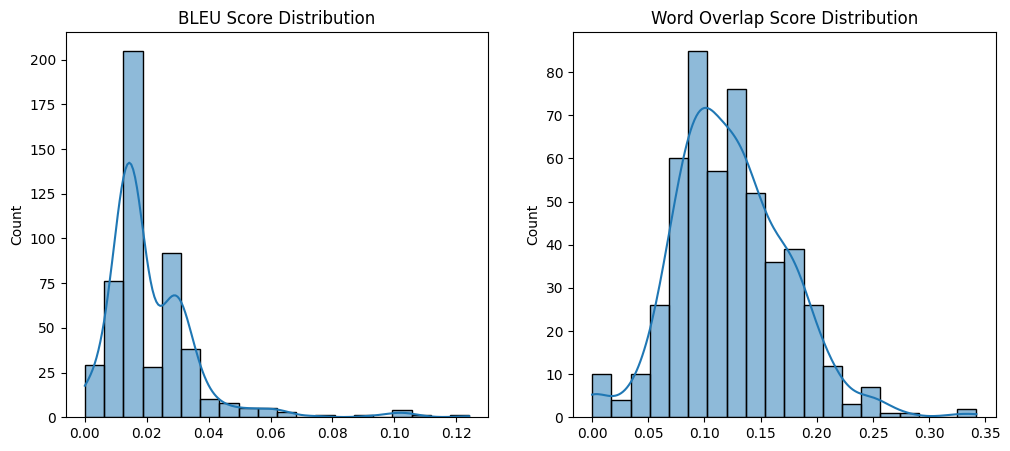

In [45]:
# Cell 6: Evaluation code for NMT
def evaluate_translation(reference, hypothesis):
    """Calculate BLEU score and other metrics"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    smoothie = SmoothingFunction().method4
    bleu_score_nmt = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)

    overlap = len(set(reference_tokens) & set(hypothesis_tokens))
    total = len(set(reference_tokens) | set(hypothesis_tokens))
    overlap_score_nmt = overlap / total if total > 0 else 0

    return {
        'bleu': bleu_score_nmt,
        'word_overlap': overlap_score_nmt
    }

bleu_scores_nmt = []
overlap_scores_nmt = []

print("Evaluating NMT model...")
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    reference = str(row['explanation'])
    hypothesis = nmt_model.translate(row['content'], sanskrit_vocab, english_vocab)

    evaluation_results = evaluate_translation(reference, hypothesis)
    bleu_scores_nmt.append(evaluation_results['bleu'])
    overlap_scores_nmt.append(evaluation_results['word_overlap'])

average_bleu_nmt = np.mean(bleu_scores_nmt)
average_overlap_nmt = np.mean(overlap_scores_nmt)

print(f"Average BLEU score: {average_bleu_nmt:.4f}")
print(f"Average Word Overlap score: {average_overlap_nmt:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(bleu_scores_nmt, bins=20, kde=True)
plt.title("BLEU Score Distribution")

plt.subplot(1, 2, 2)
sns.histplot(overlap_scores_nmt, bins=20, kde=True)
plt.title("Word Overlap Score Distribution")

plt.show()

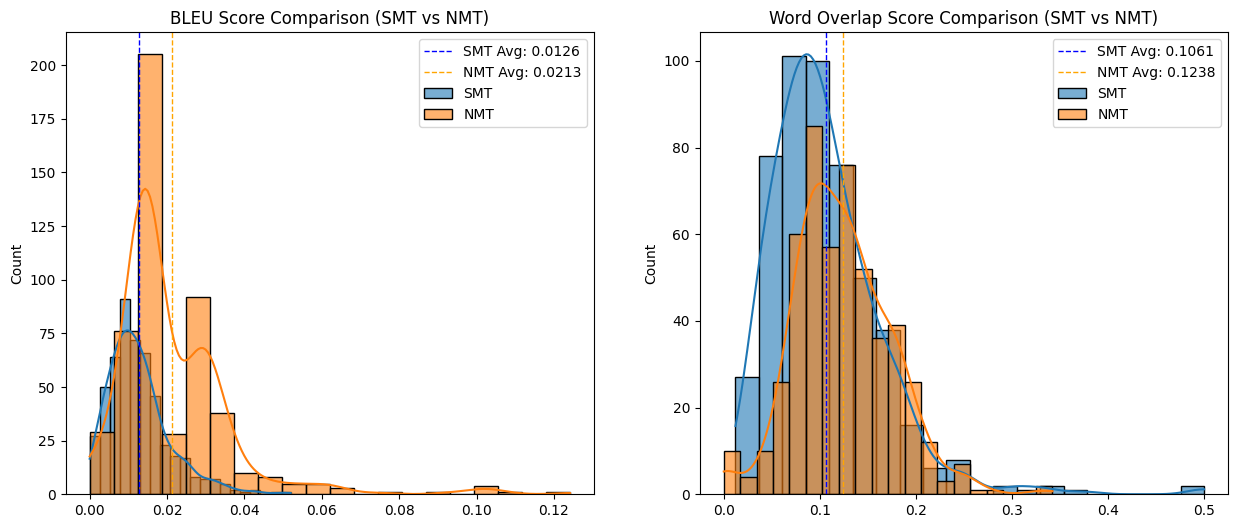

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have already run the evaluation cells and have the following variables:
# bleu_scores_smt, overlap_scores_smt, bleu_scores_nmt, overlap_scores_nmt

# Calculate average scores
avg_bleu_smt = np.mean(bleu_scores_smt)
avg_overlap_smt = np.mean(overlap_scores_smt)
avg_bleu_nmt = np.mean(bleu_scores_nmt)
avg_overlap_nmt = np.mean(overlap_scores_nmt)

# Plotting the comparison graph
plt.figure(figsize=(15, 6))

# BLEU Score Comparison
plt.subplot(1, 2, 1)
sns.histplot(bleu_scores_smt, bins=20, kde=True, label='SMT', alpha=0.6)
sns.histplot(bleu_scores_nmt, bins=20, kde=True, label='NMT', alpha=0.6)
plt.axvline(avg_bleu_smt, color='blue', linestyle='dashed', linewidth=1, label=f'SMT Avg: {avg_bleu_smt:.4f}')
plt.axvline(avg_bleu_nmt, color='orange', linestyle='dashed', linewidth=1, label=f'NMT Avg: {avg_bleu_nmt:.4f}')
plt.title("BLEU Score Comparison (SMT vs NMT)")
plt.legend()

# Word Overlap Comparison
plt.subplot(1, 2, 2)
sns.histplot(overlap_scores_smt, bins=20, kde=True, label='SMT', alpha=0.6)
sns.histplot(overlap_scores_nmt, bins=20, kde=True, label='NMT', alpha=0.6)
plt.axvline(avg_overlap_smt, color='blue', linestyle='dashed', linewidth=1, label=f'SMT Avg: {avg_overlap_smt:.4f}')
plt.axvline(avg_overlap_nmt, color='orange', linestyle='dashed', linewidth=1, label=f'NMT Avg: {avg_overlap_nmt:.4f}')
plt.title("Word Overlap Score Comparison (SMT vs NMT)")
plt.legend()

plt.show()